In [1]:
import sys

sys.path.append("../")

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

from main import *

np.random.seed(0)

Our variational approach finds the minimum energy state of the quantum system in the first quantization, and we can also extend it to find higher-energy states. In this notebook, we show this by simulating the unidimensional hydrogen atom, whose Hamiltonian is given by
$$ H = \frac{1}{2}\left( P^2 - \frac{1}{|X|} \right).$$
The first term corresponds to the electron's kinetic energy, and the second one is the potential for attraction between the electron and the nucleus due to Coulomb law.

We first define the device where we will run the simulation,

In [3]:
num_wires = 5
device = qml.device("lightning.qubit", wires=num_wires)

And assemble the $X$, $P$ and Hamiltonian operators

In [4]:
xrange = 20
X, P = X_and_P_ops(range(num_wires), -xrange, xrange)
H = [P.pow(2).s_prod(0.5), X.abs().pow(-1).s_prod(-0.5)]
H

[<Hamiltonian: terms=1, wires=[0, 1, 2, 3, 4]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2, 3, 4]>]

and, as usual, we compute an eigendecomposition with numpy for the sake of verification

In [5]:
H_matrix = tomatrix(H)
vals, vecs = np.linalg.eigh(H_matrix)
vecs = [vec for vec in vecs.T]

The eigenstates of the hydrogen atom are symmetric or antisymmetric, so we employ variational circuits with those properties. The ground state in particular is expected to be symetric, so we symmetrice our variational circuit with the function ```symmetric_ansatz```.

In [6]:
base_ansatz = ZGR_ansatz(num_wires - 1)  # 1 qubit is added at symmetrization
ansatz_sym = symmetric_ansatz(base_ansatz=base_ansatz)

var_state = ansatz_sym.construct_circuit
num_params = ansatz_sym.num_params

qml.draw_mpl(var_state, wire_order=range(num_wires))(num_params * [0])

In [8]:
varqft = VarFourier(H, device, var_state=var_state)

### Ground state

Define the `VarQFT` instance and the initial conditions,

In [9]:
print(f"Optimal energy: {vals[0]:.6f}")

params_init = 1e-3 * np.random.randn(num_params)
params_ground, energies_ground = varqft.run(
    params_init, learning_rate=0.1, conv_tol=1e-6
)

Step:    153, Energy:    -0.567446
Optimal energy: -0.567537


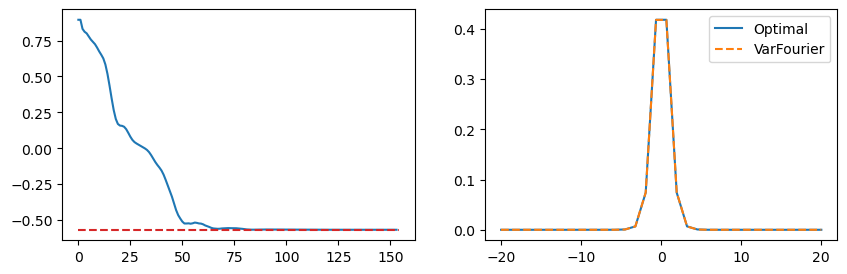

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].plot(energies_ground)
ax[0].hlines(vals[0], 0, len(energies_ground), colors="tab:red", linestyles="--")
ax[0].set_xlabel("Iteration number")
ax[0].set_ylabel("Energy")

ground_state = varqft.state(params_ground[-1])

ax[1].plot(X.eigvals(), np.abs(vecs[0]) ** 2)
ax[1].plot(X.eigvals(), np.abs(ground_state) ** 2, "--")
ax[1].legend(["Optimal", "VarFourier"])

The fidelity of our solution is:

In [11]:
fidelity = abs(np.vdot(ground_state, vecs[0])) ** 2
fidelity

0.9998875323276107

### First excited state

Now, we are going to find the first excited state. This state is antisymmetric, so we create an antisymmetric variational circuit by setting the input ```antisymmetric=True``` in the ```symmetric_ansatz``` function, and we update the variational circuit on `varqft` with the `VarFourier.set_var_state` method. Moreover, we include Langrange's multipliers in order to optimize in the subspace orthogonal to the ground state. This is done with the function `VarFourier.set_ortho`.

In [ ]:
ansatz_antisym = symmetric_ansatz(ZGR_ansatz(num_wires - 1), antisymmetric=True)

ortho_values = [25]
ortho_params = [np.copy(params_ground[-1])]
ortho_circuits = [ansatz_sym.construct_circuit]

varqft.set_var_state(ansatz_antisym.construct_circuit)

varqft.set_ortho(values=ortho_values, params=ortho_params, circuits=ortho_circuits)

In [ ]:
params_init_excited = 1e-3 * np.random.rand(num_params)

params_excited, energies_excited = varqft.run(params_ground[-1], conv_tol=1e-6)

print(f"Optimal energy: {vals[1]:.6f}")

Step:    214, Energy:    -0.138447
Optimal energy: -0.138459


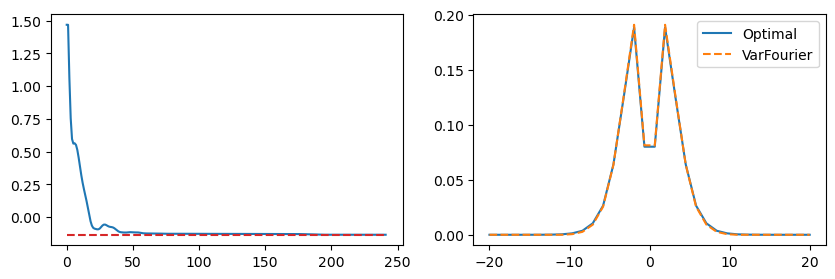

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].plot(energies_excited)
ax[0].hlines(vals[1], 0, len(energies_excited), colors="tab:red", linestyles="--")
ax[0].set_xlabel("Iteration number")
ax[0].set_ylabel("Energy")

excited_state = varqft.state(params_excited[-1])

ax[1].plot(X.eigvals(), np.abs(vecs[1]) ** 2)
ax[1].plot(X.eigvals(), np.abs(excited_state) ** 2, "--")
ax[1].legend(["Optimal", "VarFourier"])

In [15]:
fidelity = abs(np.vdot(excited_state, vecs[1])) ** 2
fidelity

0.9982445839713406

### Second excited state

The second excited state is symmetric. As before, we use update the `VarQFT` instance with the information of the excited state and use the symmetric ansatz again,

In [ ]:
varqft.add_ortho(
    values=[25],
    params=[params_excited[-1]],
    circuits=[ansatz_antisym.construct_circuit],
)

varqft.set_var_state(ansatz_sym.construct_circuit)

In [18]:
print(f"Optimal energy: {vals[2]:.6f}")

params_init_ex2 = 1e-3 * np.random.randn(num_params)
params_excited2, energies_excited2 = varqft.run(
    params_init_ex2, learning_rate=0.05, conv_tol=1e-6
)

Optimal energy: -0.055135
Step:   1000, Energy:    -0.054470


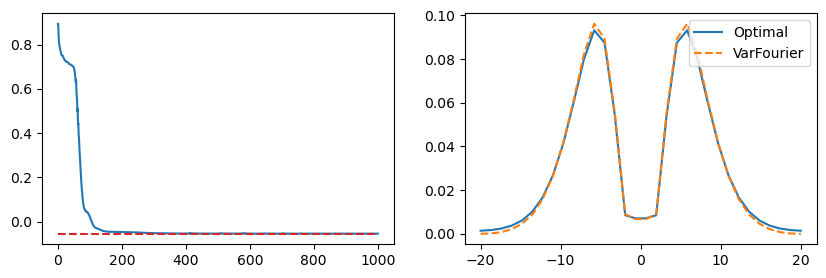

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

excited_state2 = varqft.state(params_excited2[-1])

ax[0].plot(energies_excited2)
ax[0].hlines(vals[2], 0, len(energies_excited2), colors="tab:red", linestyles="--")
ax[0].set_xlabel("Iteration number")
ax[0].set_ylabel("Energy")

ax[1].plot(X.eigvals(), np.abs(vecs[2]) ** 2)
ax[1].plot(X.eigvals(), np.abs(excited_state2) ** 2, "--")
ax[1].legend(["Optimal", "VarFourier"])

In [20]:
fidelity = abs(np.vdot(excited_state2, vecs[2])) ** 2
fidelity

0.9936579455038291

### Third excited state

Analogously for the third-excited state, which is antisymmetric.

In [21]:
varqft.add_ortho(
    values=[25], params=[params_excited2[-1]], circuits=[ansatz_sym.construct_circuit]
)

varqft.set_var_state(ansatz_antisym.construct_circuit)

In [22]:
print(f"Optimal energy: {vals[3]:.6f}")

params_init_ex3 = 1e-3 * np.random.randn(num_params)
params_excited3, energies_excited3 = varqft.run(params_init_ex3, conv_tol=1e-6)

Step:    259, Energy:    -0.030442
Optimal energy: -0.030304


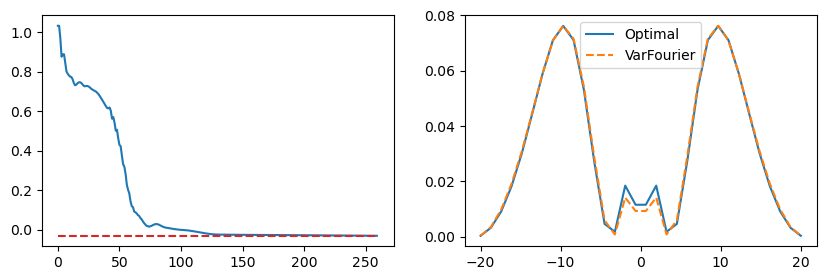

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

excited_state3 = varqft.state(params_excited3[-1])

ax[0].plot(energies_excited3)
ax[0].hlines(vals[3], 0, len(energies_excited3), colors="tab:red", linestyles="--")
ax[0].set_xlabel("Iteration number")
ax[0].set_ylabel("Energy")

ax[1].plot(X.eigvals(), np.abs(vecs[3]) ** 2)
ax[1].plot(X.eigvals(), np.abs(excited_state3) ** 2, "--")
ax[1].legend(["Optimal", "VarFourier"])

In [24]:
fidelity = abs(np.vdot(excited_state3, vecs[3])) ** 2
fidelity

0.9985304825038278

### Even the fourth excited state!

Again for the fourth-excited state, which is symmetric,

In [25]:
varqft.add_ortho(
    values=[25],
    params=[params_excited3[-1]],
    circuits=[ansatz_antisym.construct_circuit],
)

varqft.set_var_state(ansatz_sym.construct_circuit)

In [26]:
print(f"Optimal energy: {vals[4]:.6f}")

params_init_ex4 = 1e-3 * np.random.randn(num_params)
params_excited4, energies_excited4 = varqft.run(params_init_ex4, conv_tol=1e-6)

Step:    443, Energy:    -0.022228
Optimal energy: -0.022069


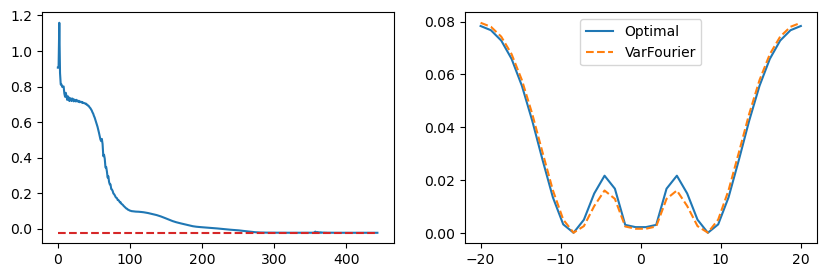

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

excited_state4 = varqft.state(params_excited4[-1])

ax[0].plot(energies_excited4)
ax[0].hlines(vals[4], 0, len(energies_excited4), colors="tab:red", linestyles="--")
ax[0].set_xlabel("Iteration number")
ax[0].set_ylabel("Energy")

ax[1].plot(X.eigvals(), np.abs(vecs[4]) ** 2)
ax[1].plot(X.eigvals(), np.abs(excited_state4) ** 2, "--")
ax[1].legend(["Optimal", "VarFourier"])

In [28]:
fidelity = abs(np.vdot(excited_state4, vecs[4])) ** 2
fidelity

0.9952418101159786

### Rydberg formula

Plotting the energies from the ground state to the fourth-excited state, we see the well-known quadratic scaling of the energies of the hydrogen atom.

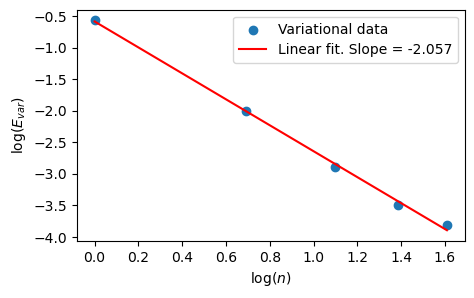

Pendiente = -2.0565392436675456


In [29]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

x = np.log(np.arange(1, 6))
y = np.log(np.abs(vals[0:5]))
ax.scatter(x, y, label="Variational data")

slope, intercept = np.polyfit(x, y, 1)
y_fit = slope * x + intercept
plt.plot(x, y_fit, color="red", label=f"Linear fit. Slope = {slope:3.3f}")

plt.xlabel(r"$\log(n)$")
plt.ylabel(r"$\log(E_{var})$")

plt.legend()
plt.savefig("../figures/Hydrogen_atom_energies.png")
plt.show()

print(f"Pendiente = {slope}")

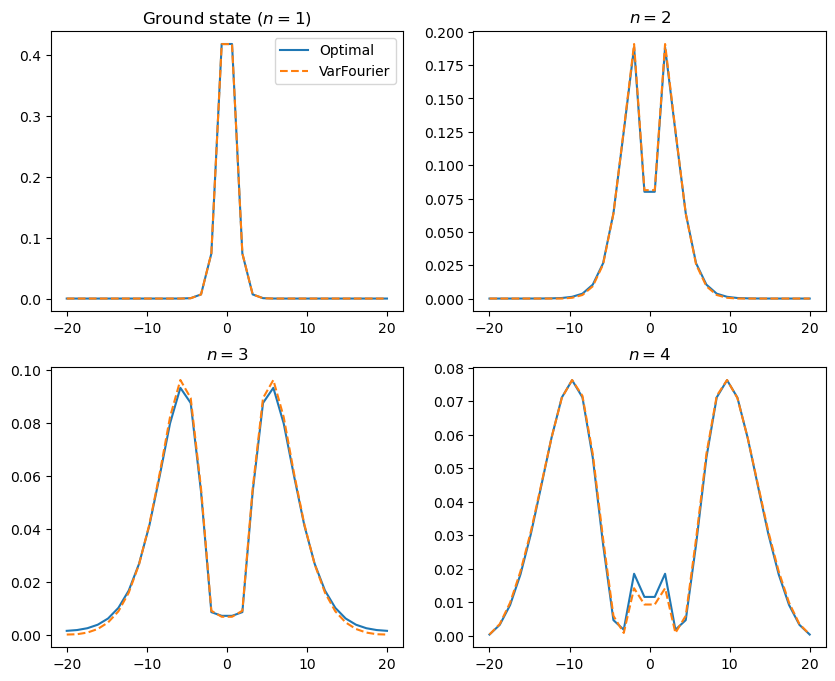

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

x = X.eigvals()
ground_state = varqft.state(params_ground[-1])

ax[0, 0].plot(x, np.abs(vecs[0]) ** 2)
ax[0, 0].plot(x, np.abs(ground_state) ** 2, "--")
ax[0, 0].legend(["Optimal", "VarFourier"])
ax[0, 0].set_title("Ground state ($n=1$)")

ax[0, 1].plot(x, np.abs(vecs[1]) ** 2)
ax[0, 1].plot(x, np.abs(excited_state) ** 2, "--")
ax[0, 1].set_title("$n=2$")

ax[1, 0].plot(x, np.abs(vecs[2]) ** 2)
ax[1, 0].plot(x, np.abs(excited_state2) ** 2, "--")
ax[1, 0].set_title("$n=3$")

ax[1, 1].plot(x, np.abs(vecs[3]) ** 2)
ax[1, 1].plot(x, np.abs(excited_state3) ** 2, "--")
ax[1, 1].set_title("$n=4$")

plt.savefig("../figures/Hydrogen_atom_first4states.png")
plt.show()

In [31]:
# np.save( 'data_H_atom', np.array([ x, vals, vecs[:4], ground_state, excited_state, excited_state2, excited_state3 ], dtype=object)  )

In [32]:
# x, vals, vecs, ground_state, excited_state, excited_state2, excited_state3 = np.load( 'data_H_atom.npy', allow_pickle=True )